# 🥑 WGAN-GP para Generación de Defectos de Aguacate
Este notebook implementa una red generativa adversarial con penalización de gradiente (WGAN-GP), con técnicas de aumento de datos, seguimiento de pérdidas y guardado del mejor modelo.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from glob import glob
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import Input
from tensorflow.compat.v1.keras.layers import Input, Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Conv2D, Flatten
from tensorflow.compat.v1.keras import layers
from tensorflow.compat.v1.keras.models import Model, Sequential
import tensorflow.compat.v1.keras.backend as K

IMG_HEIGHT, IMG_WIDTH = 128, 128
CHANNELS = 3
LATENT_DIM = 100
BATCH_SIZE = 32
EPOCHS = 5000
CRITIC_ITER = 5
LAMBDA_GP = 10


In [2]:

def load_and_augment_images(path):
    image_paths = glob("Anthracnose/defecto/*.png")
    images = []
    for img_path in image_paths:
        img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert('RGB')
        for angle in [0, 90, 180, 270]:
            rotated = img.rotate(angle)
            bright = ImageEnhance.Brightness(rotated).enhance(np.random.uniform(0.8, 1.2))
            flipped = bright.transpose(Image.FLIP_LEFT_RIGHT)
            arr = np.array(flipped).astype('float32')
            arr = (arr - 127.5) / 127.5
            images.append(arr)
    return np.array(images)

# from google.colab import drive
# drive.mount('/content/drive')

#!unzip -o "/content/drive/MyDrive/Scab_Avocado 0027_defecto.zip" -d /content/defect_images

data = load_and_augment_images("Anthracnose/defecto")

print("Total imágenes aumentadas:", data.shape)

Total imágenes aumentadas: (4088, 128, 128, 3)


In [3]:

def build_generator():
    model = Sequential()
    model.add(Input(shape=(LATENT_DIM,)))
    model.add(Dense(16 * 16 * 256))
    model.add(Reshape((16, 16, 256)))
    model.add(Conv2DTranspose(128, 4, strides=2, padding='same'))  # 32x32x128
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(64, 4, strides=2, padding='same'))   # 64x64x64
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(3, 4, strides=2, activation='tanh', padding='same'))  # 128x128x3
    return model

def build_critic():
    model = Sequential()
    model.add(Input(shape=(128, 128, 3)))
    model.add(Conv2D(64, 4, strides=2, padding='same'))  # 64x64x64
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, 4, strides=2, padding='same'))  # 32x32x128
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(1))
    return model

In [4]:

class WGANGP:
    def __init__(self):
        self.generator = build_generator()
        self.critic = build_critic()
        self.gen_opt = tf.keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9)
        self.critic_opt = tf.keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9)

    def gradient_penalty(self, real, fake):
        alpha = tf.random.uniform([real.shape[0], 1, 1, 1], 0., 1.)
        interpolated = alpha * real + (1 - alpha) * fake
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_imgs):
        batch_size = tf.shape(real_imgs)[0]
        for _ in range(CRITIC_ITER):
            noise = tf.random.normal((batch_size, LATENT_DIM))
            with tf.GradientTape() as tape:
                fake_imgs = self.generator(noise, training=True)
                real_validity = self.critic(real_imgs, training=True)
                fake_validity = self.critic(fake_imgs, training=True)
                gp = self.gradient_penalty(real_imgs, fake_imgs)
                d_loss = tf.reduce_mean(fake_validity) - tf.reduce_mean(real_validity) + LAMBDA_GP * gp
            grads = tape.gradient(d_loss, self.critic.trainable_variables)
            self.critic_opt.apply_gradients(zip(grads, self.critic.trainable_variables))

        noise = tf.random.normal((batch_size, LATENT_DIM))
        with tf.GradientTape() as tape:
            gen_imgs = self.generator(noise, training=True)
            fake_validity = self.critic(gen_imgs, training=True)
            g_loss = -tf.reduce_mean(fake_validity)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.gen_opt.apply_gradients(zip(grads, self.generator.trainable_variables))
        return d_loss, g_loss

    def generate_and_plot(self, epoch, examples=5):
        noise = tf.random.normal((examples, LATENT_DIM))
        gen_imgs = self.generator(noise, training=False)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(1, examples, figsize=(15,3))
        for i in range(examples):
            axs[i].imshow(gen_imgs[i])
            axs[i].axis('off')
        plt.savefig(f"WGAN-GP/0.wgan_gp_epoch_{epoch}.png")
        plt.show()


Epoch 0 - D loss: 1.8925 - G loss: -0.0156


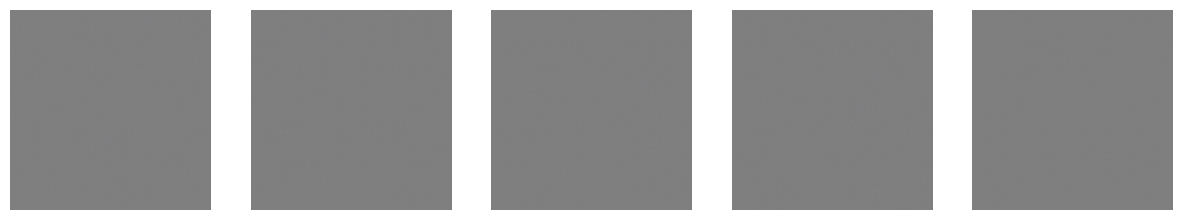

Epoch 200 - D loss: -9.0729 - G loss: -104.2208


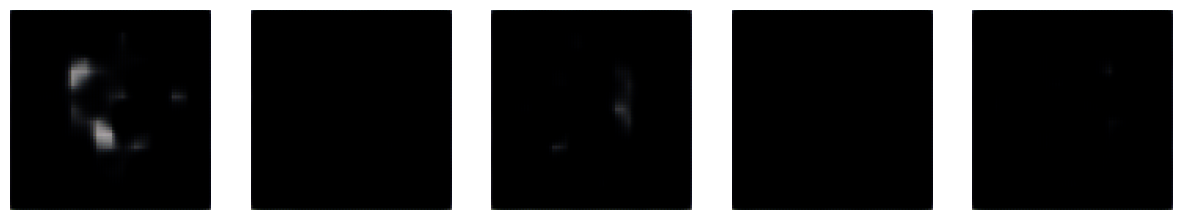

Epoch 400 - D loss: -4.7209 - G loss: -144.7937


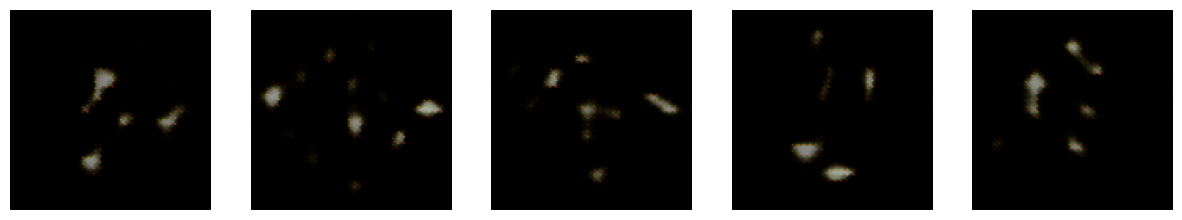

Epoch 600 - D loss: -2.7421 - G loss: -56.8499


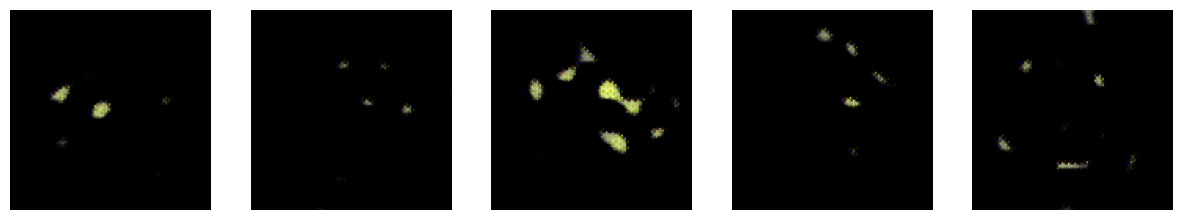

Epoch 800 - D loss: -2.7465 - G loss: -25.3047


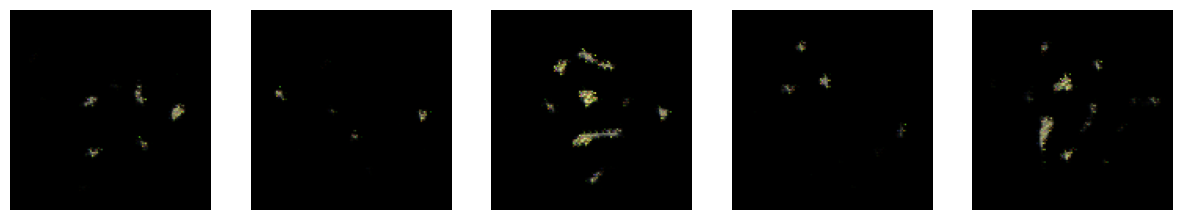

Epoch 1000 - D loss: -4.5820 - G loss: 57.6060


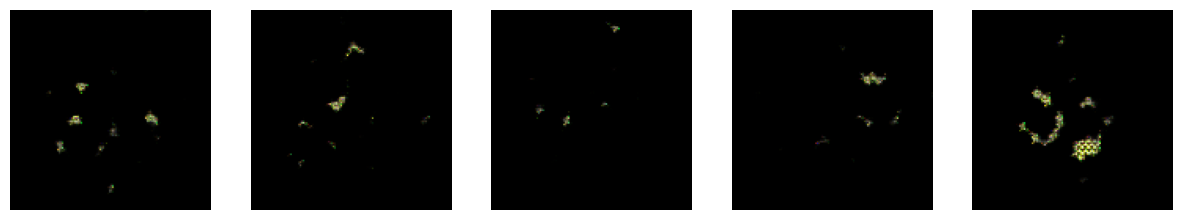

Epoch 1200 - D loss: -5.5651 - G loss: 30.6893


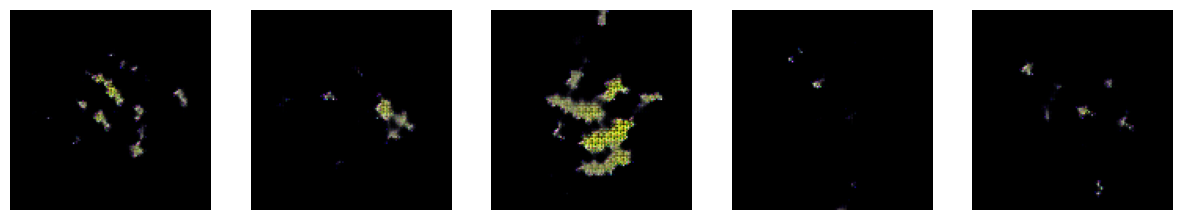

Epoch 1400 - D loss: -5.1414 - G loss: 11.7126


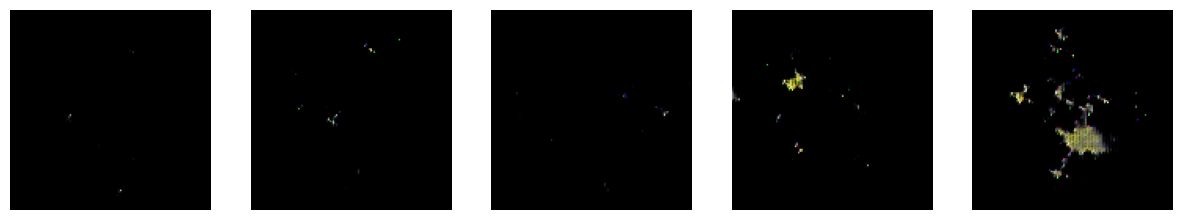

Epoch 1600 - D loss: -5.5848 - G loss: 44.3462


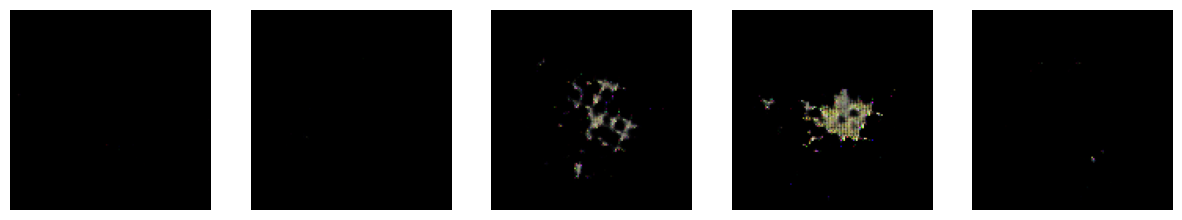

Epoch 1800 - D loss: -4.4993 - G loss: 73.7691


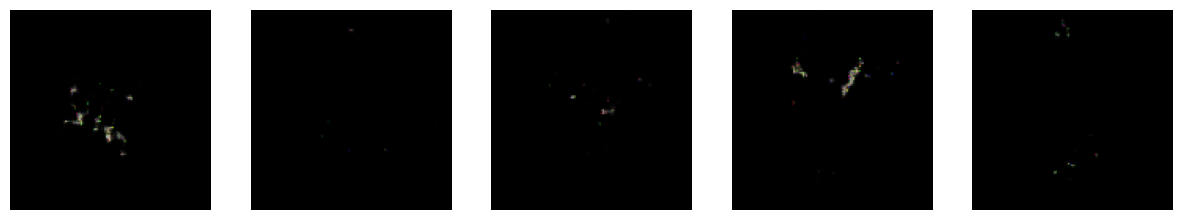

Epoch 2000 - D loss: -3.9618 - G loss: -14.7501


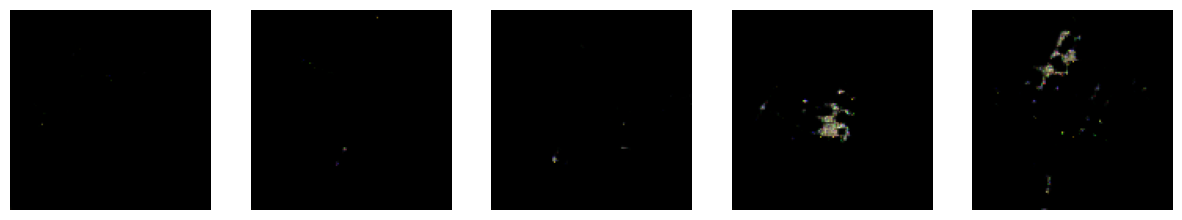

Epoch 2200 - D loss: -6.3853 - G loss: -48.3096


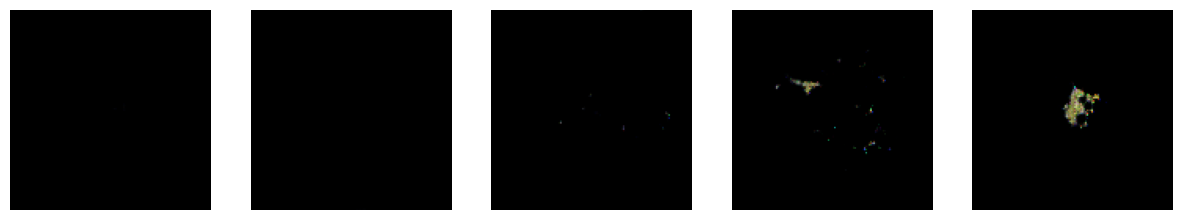

Epoch 2400 - D loss: -4.5212 - G loss: -4.1348


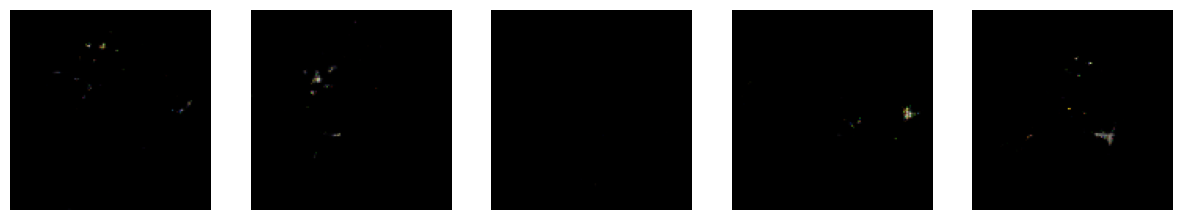

Epoch 2600 - D loss: -3.3765 - G loss: -53.3700


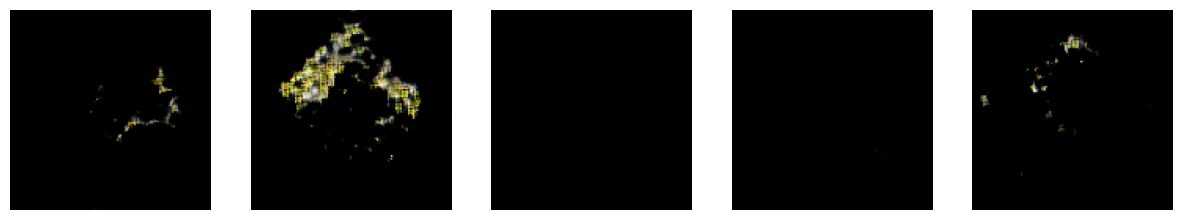

Epoch 2800 - D loss: -2.8456 - G loss: -89.7868


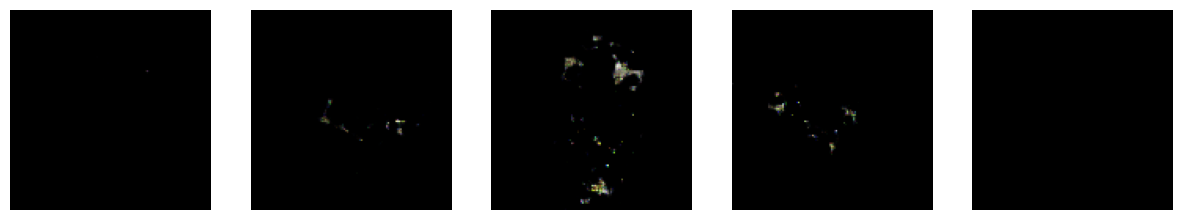

Epoch 3000 - D loss: -4.3066 - G loss: -122.2552


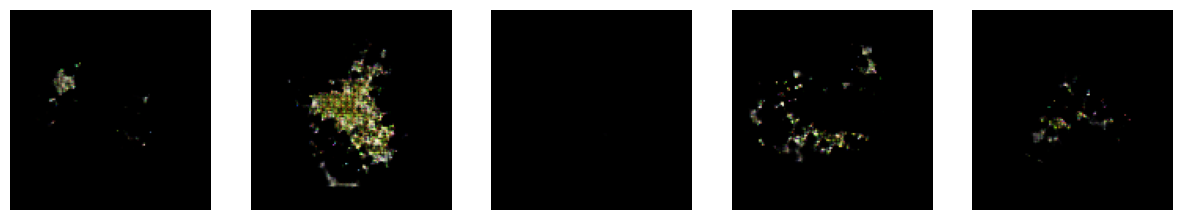

Epoch 3200 - D loss: -2.2370 - G loss: -92.1343


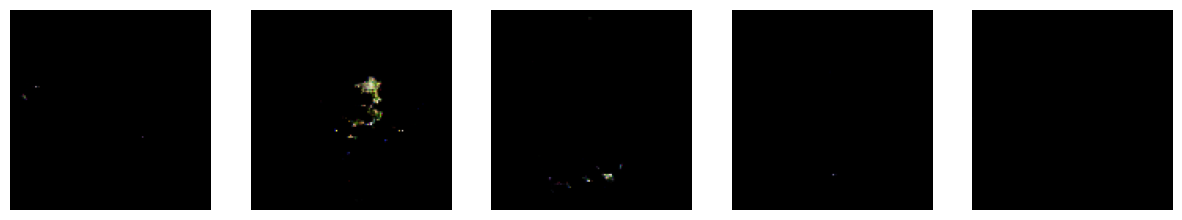

Epoch 3400 - D loss: -2.5062 - G loss: -115.9619


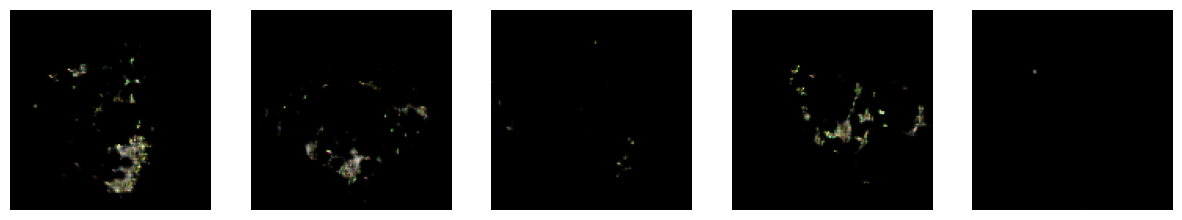

Epoch 3600 - D loss: -7.7382 - G loss: -190.8510


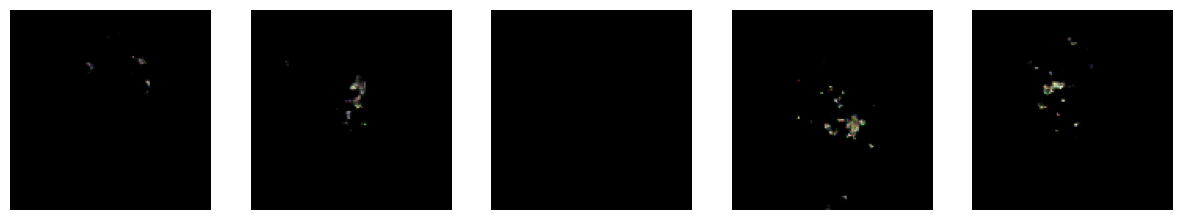

Epoch 3800 - D loss: -5.4041 - G loss: -22.1918


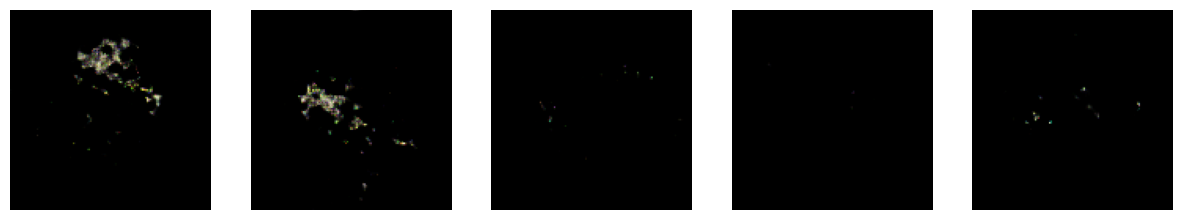

Epoch 4000 - D loss: -3.2297 - G loss: -51.8569


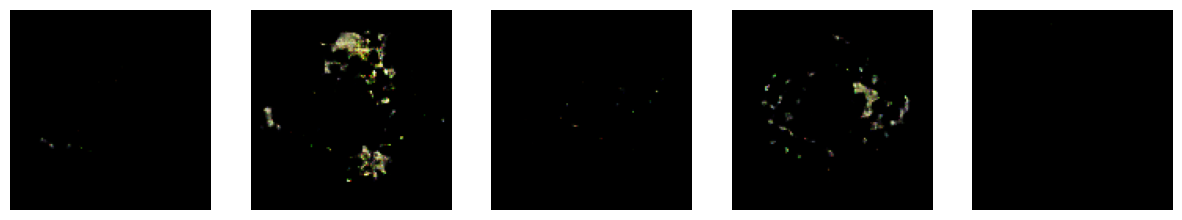

Epoch 4200 - D loss: -2.6158 - G loss: -20.7041


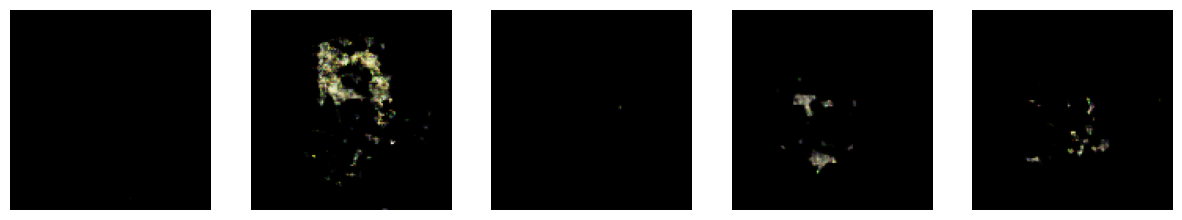

Epoch 4400 - D loss: -2.2468 - G loss: -24.2821


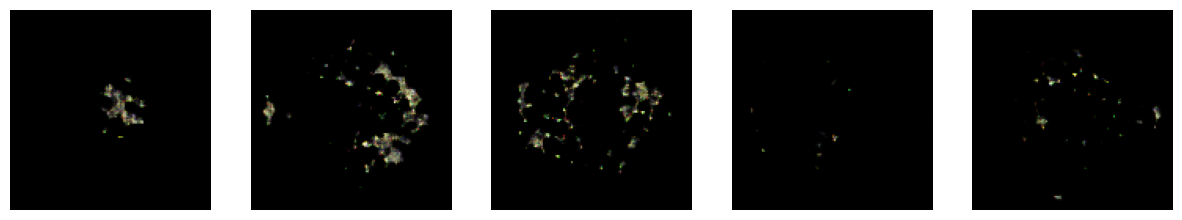

Epoch 4600 - D loss: -4.7051 - G loss: -12.0738


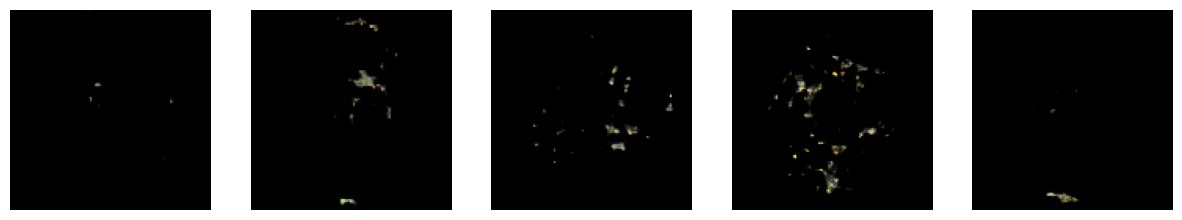

Epoch 4800 - D loss: -4.2659 - G loss: -124.2879


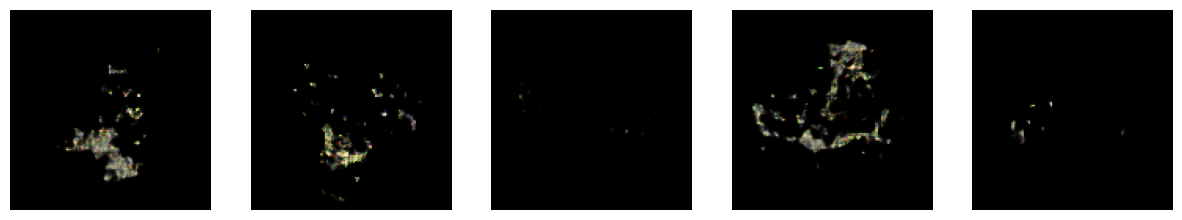

Epoch 5000 - D loss: -2.2184 - G loss: -13.7738


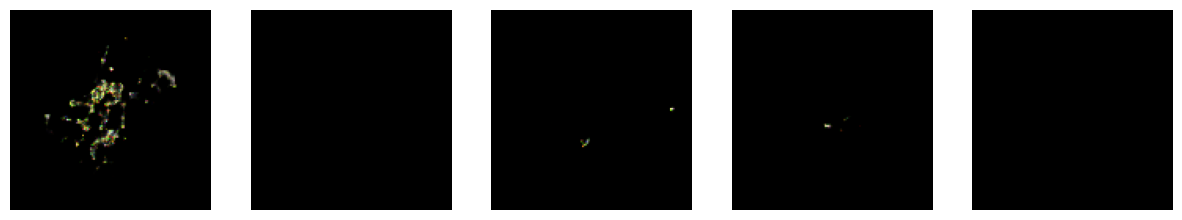

In [5]:
wgan = WGANGP()
g_losses = []
d_losses = []
best_g_loss = float('inf')

for epoch in range(EPOCHS + 1):
    idx = np.random.randint(0, data.shape[0], BATCH_SIZE)
    real_imgs = data[idx]
    d_loss, g_loss = wgan.train_step(real_imgs)
    d_losses.append(float(d_loss))
    g_losses.append(float(g_loss))

    if epoch % 200 == 0:
        print(f"Epoch {epoch} - D loss: {d_loss:.4f} - G loss: {g_loss:.4f}")
        wgan.generator.save(f"WGAN-GP/best_generator_epoch_{epoch}.keras")
        wgan.generate_and_plot(epoch)
        


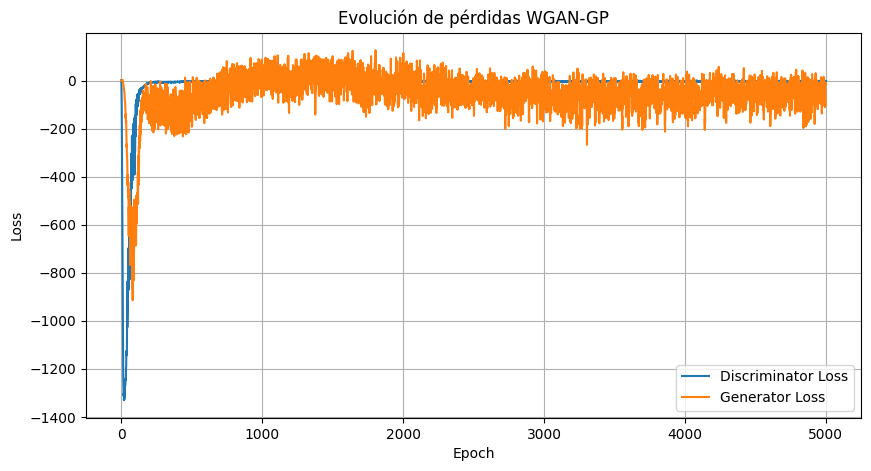

In [6]:

# Graficar pérdidas
plt.figure(figsize=(10,5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Evolución de pérdidas WGAN-GP")
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 157ms/step


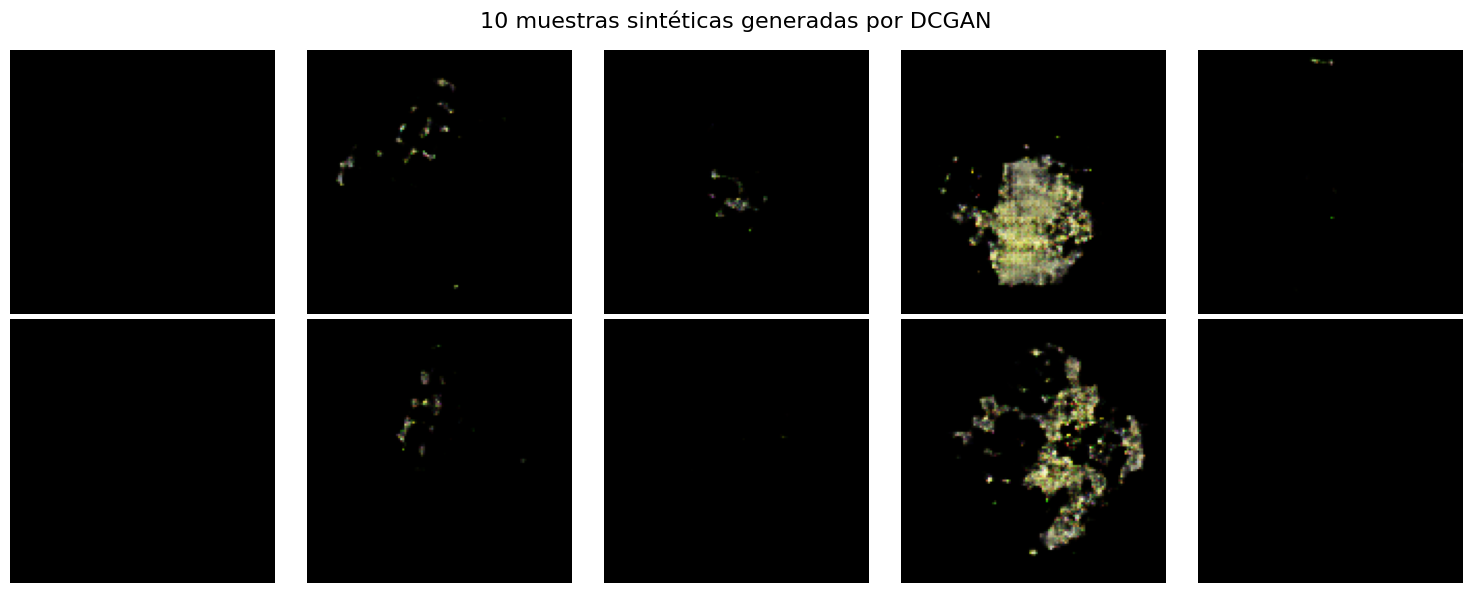

In [7]:
# 3. Cargar modelo y generar muestras
from tensorflow.keras.models import load_model
generator = load_model("WGAN-GP/best_generator_epoch_5000.keras")

noise = np.random.normal(0, 1, (10, 100))

# Generar imágenes sintéticas
generated_imgs = generator.predict(noise)
generated_imgs = 0.5 * generated_imgs + 0.5  # desnormalizar (de [-1, 1] a [0, 1])

# Mostrar imágenes: 2 filas, 5 columnas
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_imgs[i])
    plt.axis("off")

plt.suptitle("10 muestras sintéticas generadas por DCGAN", fontsize=16)
plt.tight_layout()
plt.show()



In [1]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

# 1. Cargar el modelo generador
generator = load_model("WGAN-GP/best_generator_epoch_5000.keras")

# 2. Crear carpeta para guardar imágenes
output_dir = "generated-p"
os.makedirs(output_dir, exist_ok=True)

# 3. Generar y guardar 200 imágenes en lotes de 20
n_total = 200
batch_size = 20
latent_dim = 100

for batch_start in range(0, n_total, batch_size):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_imgs = generator.predict(noise)
    generated_imgs = 0.5 * generated_imgs + 0.5  # desnormalizar
    generated_imgs = (generated_imgs * 255).astype(np.uint8)

    for i in range(batch_size):
        index = batch_start + i
        img_array = generated_imgs[i]
        img_pil = Image.fromarray(img_array, mode="RGB")
        img_pil.save(os.path.join(output_dir, f"generated_{index:03d}.png"))

print(f"✅ Se guardaron 200 imágenes en la carpeta '{output_dir}'")


1/1 [==============================] - 0s 118ms/step
✅ Se guardaron 200 imágenes en la carpeta 'generated-p'
